# Google Colab Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/DataScience/machine_learning/competitions/kaggle/Titanic

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DataScience/machine_learning/competitions/kaggle/Titanic


In [ ]:
import os
import sys

# Create folders to 
PROJECT_ROOT_DIR = "."
folder_path = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(folder_path, exist_ok=True)

sys.path.append('/content/drive/MyDrive/DataScience/machine_learning')

import utils

# Libraries

In [ ]:
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# Data scaling
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

# Evaluation
from sklearn.metrics import mean_squared_error

In [ ]:
# Libraries for custom Transformer
from sklearn.base import BaseEstimator, TransformerMixin

# Data Loading

In [ ]:
import pandas as pd
PROJECT_ROOT = '/content/drive/MyDrive/DataScience/machine_learning/competitions/kaggle/Titanic'

train = pd.read_csv(os.path.join(PROJECT_ROOT, 'datasets', 'train.csv'))
test = pd.read_csv(os.path.join(PROJECT_ROOT, 'datasets', 'test.csv'))

In [ ]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [ ]:
train.shape

(891, 12)

In [ ]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [ ]:
train = train.set_index('PassengerId')
test = test.set_index('PassengerId')

# Data Type

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [ ]:
num_cols = [col for col in train.columns if train[col].dtype in ['int64', 'float64']]
cat_cols = [col for col in train.columns if train[col].dtype in ['object']]

print('num_cols:', num_cols)
print('cat_cols:', cat_cols)

num_cols: ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
cat_cols: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


In [ ]:
card = [train[col].nunique() for col in cat_cols]
for a, b in zip(cat_cols, card):
    print(a, b)

low_card_cols = [col for col in cat_cols if train[col].nunique() <= 10]
high_card_cols = [col for col in cat_cols if train[col].nunique() > 10]
print('low_card_cols:', low_card_cols)
print('high_card_cols:', high_card_cols)

Name 891
Sex 2
Ticket 681
Cabin 147
Embarked 3
low_card_cols: ['Sex', 'Embarked']
high_card_cols: ['Name', 'Ticket', 'Cabin']


# Data Cleaning

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [ ]:
# Inpute Age column with median age of the corresponding class
pclass = train.Pclass.unique()
median_age_pclass = [train[train['Pclass'] == c]['Age'].median() for c in pclass]
print('median_age_pclass:', median_age_pclass)

# TODO: finish custom class for imputing median_age_pclass

median_age_pclass: [24.0, 37.0, 29.0]


## Filling NaN Values

In [ ]:
imputer = ColumnTransformer([
    ('imputer_num', SimpleImputer(strategy='median'), num_cols),
    ('imputer_cat', SimpleImputer(strategy='most_frequent'), cat_cols)
])

In [ ]:
clean_pipe = Pipeline([
    ('imputer', imputer)
])

In [ ]:
train_clean = imputer.fit_transform(train)
train_clean

array([[0.0, 3.0, 22.0, ..., 'A/5 21171', 'B96 B98', 'S'],
       [1.0, 1.0, 38.0, ..., 'PC 17599', 'C85', 'C'],
       [1.0, 3.0, 26.0, ..., 'STON/O2. 3101282', 'B96 B98', 'S'],
       ...,
       [0.0, 3.0, 28.0, ..., 'W./C. 6607', 'B96 B98', 'S'],
       [1.0, 1.0, 26.0, ..., '111369', 'C148', 'C'],
       [0.0, 3.0, 32.0, ..., '370376', 'B96 B98', 'Q']], dtype=object)

In [ ]:
train_clean = pd.DataFrame(train_clean)
train_clean.columns = num_cols + cat_cols
train_clean.set_index(train.index)
train_clean.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Name,Sex,Ticket,Cabin,Embarked
0,0.0,3.0,22.0,1.0,0.0,7.25,"Braund, Mr. Owen Harris",male,A/5 21171,B96 B98,S
1,1.0,1.0,38.0,1.0,0.0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,1.0,3.0,26.0,0.0,0.0,7.925,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,B96 B98,S
3,1.0,1.0,35.0,1.0,0.0,53.1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,0.0,3.0,35.0,0.0,0.0,8.05,"Allen, Mr. William Henry",male,373450,B96 B98,S


In [ ]:
train_clean.shape

(891, 11)

In [ ]:
# After imputing, all dtype will change to 'object'
# So need to reassign float64 type to num_cols
X_ = train_clean[num_cols].astype('float64')
train_clean = X_.join(train_clean[cat_cols])

In [ ]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    891 non-null    float64
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    float64
 4   Parch     891 non-null    float64
 5   Fare      891 non-null    float64
 6   Name      891 non-null    object 
 7   Sex       891 non-null    object 
 8   Ticket    891 non-null    object 
 9   Cabin     891 non-null    object 
 10  Embarked  891 non-null    object 
dtypes: float64(6), object(5)
memory usage: 76.7+ KB


# Data Analysis

In [ ]:
train_clean.head(2)

,Survived,Pclass,Age,SibSp,Parch,Fare,Name,Sex,Ticket,Cabin,Embarked
0,0.0,3.0,22.0,1.0,0.0,7.2500,"Braund, Mr. Owen Harris",male,A/5 21171,B96 B98,S
1,1.0,1.0,38.0,1.0,0.0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C


In [ ]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    891 non-null    float64
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    float64
 4   Parch     891 non-null    float64
 5   Fare      891 non-null    float64
 6   Name      891 non-null    object 
 7   Sex       891 non-null    object 
 8   Ticket    891 non-null    object 
 9   Cabin     891 non-null    object 
 10  Embarked  891 non-null    object 
dtypes: float64(6), object(5)
memory usage: 76.7+ KB


## Correaltions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc738473fd0>,
      dtype=object)

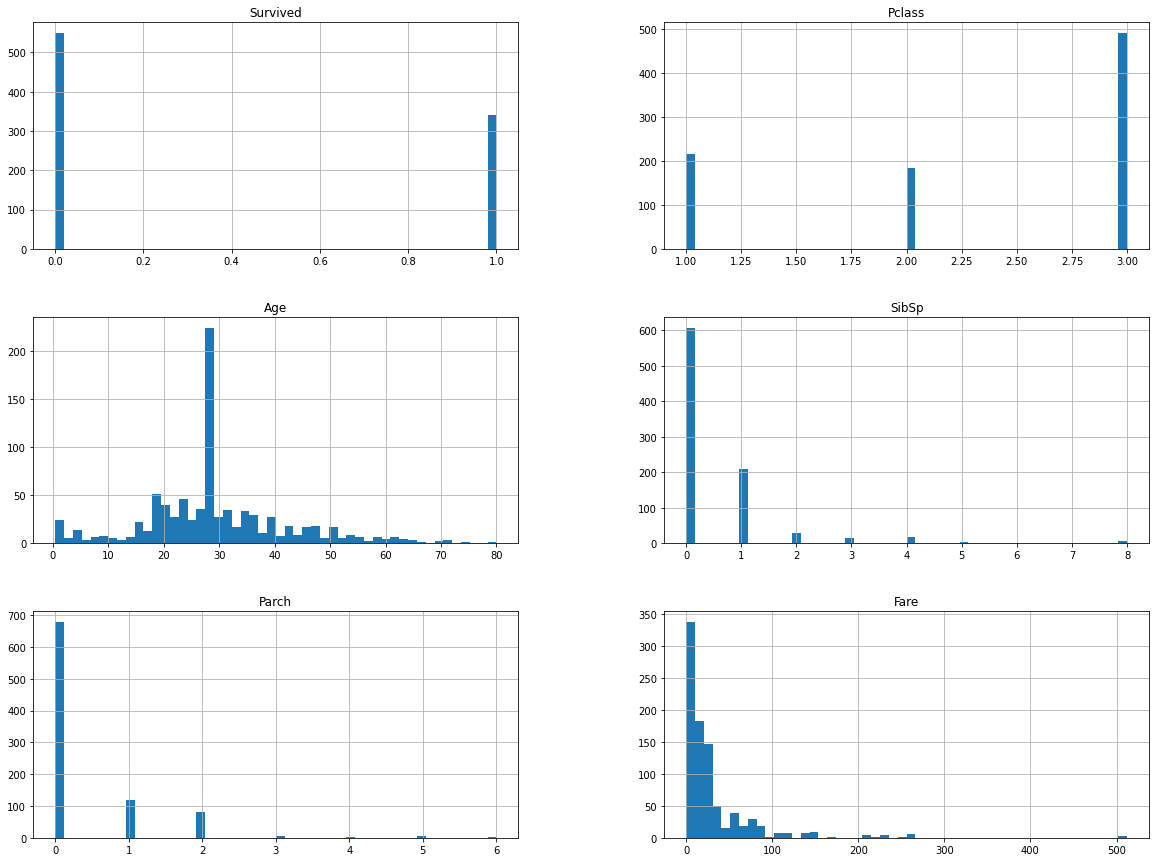

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
train_clean.hist(bins=50, figsize=(20,15))

In [ ]:
corr = train_clean.corr()
corr['Survived'].sort_values(ascending=False)

Survived    1.000000
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.064910
Pclass     -0.338481
Name: Survived, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc737e24c10>,
      dtype=object)

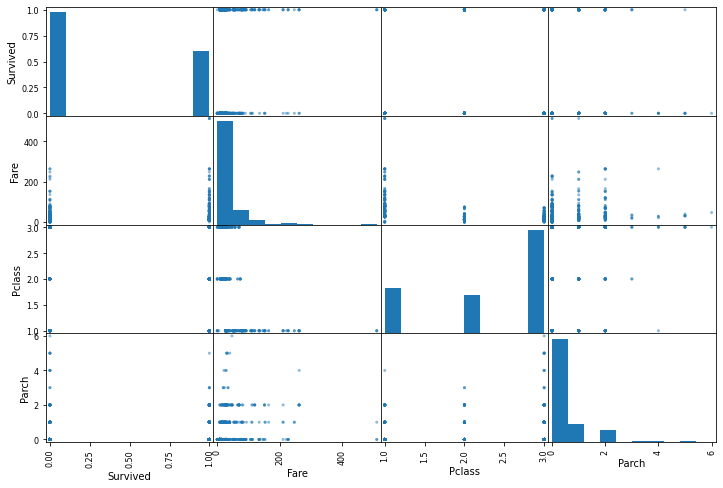

In [ ]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["Survived", "Fare", "Pclass",
              "Parch"]
scatter_matrix(train_clean[attributes], figsize=(12, 8))
# save_fig("scatter_matrix_plot")

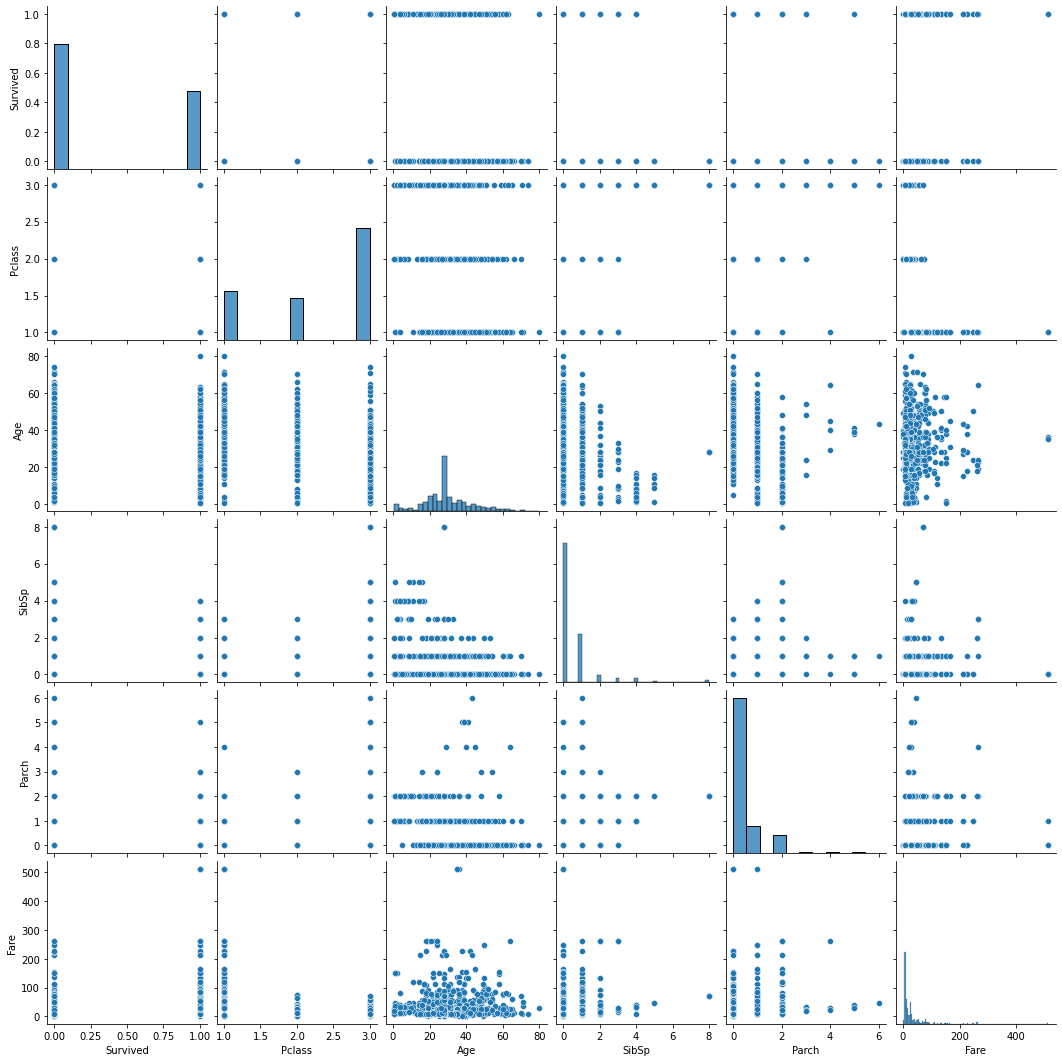

In [ ]:
import seaborn as sns
sns.pairplot(train_clean, palette='Dark2')

## Age Bucket
Divide ages into several intervals, that each age interval will have different survival rate

In [ ]:
train_clean['AgeBucket'] = train_clean['Age'] // 15 * 15
train_clean[['AgeBucket', 'Survived']].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.337474
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


## Relatives On Board

In [ ]:
train_clean['RelativesOnboard'] = train_clean.SibSp + train_clean.Parch
train_clean[['RelativesOnboard', 'Survived']].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0.0,0.303538
1.0,0.552795
2.0,0.578431
3.0,0.724138
4.0,0.200000
5.0,0.136364
6.0,0.333333
7.0,0.000000
10.0,0.000000


## Name Title

In [ ]:
train_clean.Name.head(20)

0                               Braund, Mr. Owen Harris
1     Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss. Laina
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                              Allen, Mr. William Henry
5                                      Moran, Mr. James
6                               McCarthy, Mr. Timothy J
7                        Palsson, Master. Gosta Leonard
8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                   Nasser, Mrs. Nicholas (Adele Achem)
10                      Sandstrom, Miss. Marguerite Rut
11                             Bonnell, Miss. Elizabeth
12                       Saundercock, Mr. William Henry
13                          Andersson, Mr. Anders Johan
14                 Vestrom, Miss. Hulda Amanda Adolfina
15                     Hewlett, Mrs. (Mary D Kingcome) 
16                                 Rice, Master. Eugene
17                         Williams, Mr. Charles

In [ ]:
def extract(name, titles):
    for t in titles:
        if t in name:
            return t
    return np.nan

title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                    'Don', 'Jonkheer']

train_clean['Title'] = train_clean['Name'].map(lambda name: extract(name, title_list))


In [ ]:
for a, b in zip(train_clean.Title.head(10), train_clean.Name.head(10)):
    print(a, ',', b)


Mr , Braund, Mr. Owen Harris
Mrs , Cumings, Mrs. John Bradley (Florence Briggs Thayer)
Miss , Heikkinen, Miss. Laina
Mrs , Futrelle, Mrs. Jacques Heath (Lily May Peel)
Mr , Allen, Mr. William Henry
Mr , Moran, Mr. James
Mr , McCarthy, Mr. Timothy J
Master , Palsson, Master. Gosta Leonard
Mrs , Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
Mrs , Nasser, Mrs. Nicholas (Adele Achem)


In [ ]:
train_clean[train_clean.Title.isna()]
# Or: # train_clean[train_clean.Title.isnull()]

,Survived,Pclass,Age,SibSp,Parch,Fare,Name,Sex,Ticket,Cabin,Embarked,AgeBucket,RelativesOnboard,Title


In [ ]:
train_clean.Title.value_counts()

Mr          518
Miss        180
Mrs         129
Master       40
Dr            7
Rev           6
Major         2
Col           2
Don           1
Mme           1
Ms            1
Mlle          1
Capt          1
Countess      1
Jonkheer      1
Name: Title, dtype: int64

In [ ]:
train_clean.shape

(891, 14)

## Cabin to Deck 

In [ ]:
train_clean.Cabin.head(10)

0    B96 B98
1        C85
2    B96 B98
3       C123
4    B96 B98
5    B96 B98
6        E46
7    B96 B98
8    B96 B98
9    B96 B98
Name: Cabin, dtype: object

In [ ]:
#Turning cabin number into Deck
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
train_clean['Deck'] = train_clean['Cabin'].map(lambda x: extract(x, cabin_list))

In [ ]:
for a, b in zip(train_clean.Deck.head(10), train_clean.Cabin.head(10)):
    print(a, ',', b)

B , B96 B98
C , C85
B , B96 B98
C , C123
B , B96 B98
B , B96 B98
E , E46
B , B96 B98
B , B96 B98
B , B96 B98


## Surname

In [ ]:
train_clean.Name.head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [ ]:
train_clean['Surname'] = train_clean['Name'].map(lambda x: x.split(',', 1)[0])

In [ ]:
train_clean.Surname

0         Braund
1        Cumings
2      Heikkinen
3       Futrelle
4          Allen
         ...    
886     Montvila
887       Graham
888     Johnston
889         Behr
890       Dooley
Name: Surname, Length: 891, dtype: object

In [ ]:
# list of unique values
surname_unique = train_clean.Surname.unique()

In [ ]:
surname_value_counts = train_clean.Surname.value_counts()

In [ ]:
num_passenger = len(train_clean)
surname_one_lived = [0]*num_passenger
num_sur_died = [0]*len(surname_unique)

surname_dic = dict(zip(surname_unique, num_sur_died))
# print(surname_dic)

for index, row in train_clean.iterrows():
    if row['Survived'] == 0:
        surname_dic[row['Surname']] += 1

# print(surname_dic)


In [ ]:
t = list(surname_dic.values())
surname_all_died = [surname_unique[i] for i in range(len(t)) if t[i] > 2]
print(surname_all_died)

['Palsson', 'Johnson', 'Andersson', 'Rice', 'Williams', 'Vander Planke', 'Panula', 'Goodwin', 'Skoog', 'Ford', 'Johansson', 'Gustafsson', 'Hickman', 'Boulos', 'Olsen', 'Sage', 'Smith', 'Lefebre', 'Bourke', 'Elias', 'Van Impe', 'Hansen', 'Jensen']


In [ ]:
## Seems not working
# lalala = train_clean.copy()
# lalala['SurnameAllDied'] = 1 if lalala['Surname'] in surname_all_died else 0
# lalala['SurnameAllDied'] = np.where(lalala['Surname'] in surname_all_died, 1, 0)
# lalala['SurnameAllDied']
# df['color'] = np.where(df['Set']=='Z', 'green', 'red')

i = 0
train_clean['SurnameAllDied'] = 0
for row in train_clean['Surname']:
    if row in surname_all_died:
        train_clean['SurnameAllDied'][i] = 1
    i += 1

# train_clean.SurnameAllDied[:10]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [ ]:
corr = train_clean.corr()
corr['Survived'].sort_values(ascending=False)

# It shows that SurnameAllDied column has a really strong correlation with label

Survived            1.000000
Fare                0.257307
Parch               0.081629
RelativesOnboard    0.016639
AgeBucket          -0.028922
SibSp              -0.035322
Age                -0.064910
SurnameAllDied     -0.227646
Pclass             -0.338481
Name: Survived, dtype: float64

In [ ]:
surname_dic = None
surname_all_died = None
surname_count = None

def create_surname(df):
    df['Surname'] = df['Name'].map(lambda x: x.split(',', 1)[0])
    return df

def create_surname_all_died(df):
    global surname_dic, surname_all_died, surname_count

    # Create Surname Columns
    # df['Surname'] = df['Name'].map(lambda x: x.split(',', 1)[0])
    df = create_surname(df)
    surname_unique = df.Surname.unique()

    # num_passenger = len(df)
    # surname_one_lived = [0]*num_passenger
    l = [0]*len(surname_unique)

    surname_dic = dict(zip(surname_unique, l))

    surname_count = dict(zip(surname_unique, l))
    for index, row in df.iterrows():
        surname_count[row["Surname"]] += 1
        if row['Survived'] == 0:
            surname_dic[row['Surname']] += 1
    print(surname_count)
    
    t = list(surname_dic.values())
    surname_all_died = [surname_unique[i] for i in range(len(t)) if t[i] > 2]
    # print(surname_all_died)

    i = 0
    df['SurnameAllDied'] = 0
    for row in df['Surname']:
        if row in surname_all_died:
            df['SurnameAllDied'][i] = 1
        i += 1

    return df


In [ ]:
def create_survived(df):
    global surname_dic, surname_all_died, surname_count
    df = create_surname(df)     # Create df['Surname']
    # df['Survived'] = 0
    df['SurnameAllDied'] = 0
    for s in df.Surname:
        if s not in surname_count or surname_count[s] == 1:
            df['SurnameAllDied'] = 0
        elif surname_dic[s] >= 2:
            df['SurnameAllDied'] = 1

    print(df[:10])
    return df

# Data Split

In [ ]:
# Data split

y_train = train_clean['Survived']
X_train = train_clean.drop(['Survived'], axis=1)

In [97]:
from sklearn.model_selection import train_test_split

train_split, test_split = train_test_split(train, test_size=0.2)

In [98]:
X_train_split = train_split.drop(['Survived'], axis=1)
y_train_split = train_split['Survived']

X_test_split = test_split.drop(['Survived'], axis=1)
y_test_split = test_split['Survived']

# Pipleline & Transformer

## Columns Identifying

In [ ]:
X_train.dtypes

Pclass              float64
Age                 float64
SibSp               float64
Parch               float64
Fare                float64
Name                 object
Sex                  object
Ticket               object
Cabin                object
Embarked             object
AgeBucket           float64
RelativesOnboard    float64
Title                object
Deck                 object
Surname              object
SurnameAllDied        int64
dtype: object

In [ ]:
# num_cols = ['Pclass', 'SibSp', 'Parch', 'Fare', 'AgeBucket', 'RelativesOnboard']
# cat_cols = ['Sex', 'Embarked', 'Title', 'Deck']

# num_cols = ['Pclass', 'Age', 'Parch', 'Fare', 'SibSp']
# cat_cols = ['Sex', 'Embarked', 'Title', 'Deck']
num_cols = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]
cat_cols = [col for col in X_train.columns if X_train[col].dtype in ['object']]

print('num_cols:', num_cols)
print('cat_cols:', cat_cols)

num_cols: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'AgeBucket', 'RelativesOnboard', 'SurnameAllDied']
cat_cols: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Title', 'Deck', 'Surname']


In [ ]:
card = [X_train[col].nunique() for col in cat_cols]
for a, b in zip(cat_cols, card):
    print(a, b)

low_card_cols = [col for col in cat_cols if X_train[col].nunique() <= 10]
high_card_cols = [col for col in cat_cols if X_train[col].nunique() > 10]
print('low_card_cols:', low_card_cols)
print('high_card_cols:', high_card_cols)

Name 891
Sex 2
Ticket 681
Cabin 147
Embarked 3
Title 15
Deck 8
Surname 667
low_card_cols: ['Sex', 'Embarked', 'Deck']
high_card_cols: ['Name', 'Ticket', 'Cabin', 'Title', 'Surname']


## High Cardinality ColsTrans

In [ ]:
# High Cardinality Transformer: perform one-hot transformer for high-cardinality
# columns while avoiding generating too much dummpy features. It will only one-hot
# the classes with high proportion. A threshold can be set.

from collections import Counter

def cumulatively_categorise(column,threshold=0.9,return_categories_list=True):
    #Find the threshold value using the percentage and number of instances in the column
    threshold_value=int(threshold*len(column))
    #Initialise an empty list for our new minimised categories
    categories_list=[]
    #Initialise a variable to calculate the sum of frequencies
    s=0
    #Create a counter dictionary of the form unique_value: frequency
    counts=Counter(column)

    #Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
    for i,j in counts.most_common():
        #Add the frequency to the global sum
        s+=dict(counts)[i]
        #Append the category name to the list
        categories_list.append(i)
        #Check if the global sum has reached the threshold value, if so break the loop
        if s>=threshold_value:
            break
    #Append the category Other to the list
    categories_list.append('Other')

    #Replace all instances not in our new categories by Other  
    new_column=column.apply(lambda x: x if x in categories_list else 'Other')

    #Return transformed column and unique values if return_categories=True
    if(return_categories_list):
        return new_column,categories_list
    #Return only the transformed column if return_categories=False
    else:
        return new_column

In [ ]:
# high_card_cols = ['Regionname', 'CouncilArea']
class HighCardAggregation(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
        pass

    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        X_ = X.copy()
        X_df = pd.DataFrame(X, columns=self.cols)
        
        for col in self.cols:
            # transformed_columns is a pandas dataframe
            transformed_column, trans_list = cumulatively_categorise(column=X_df[col], threshold=0.9)
            X_ = np.c_[X_, transformed_column.to_numpy()]
            
        X_ = np.delete(X_, [i for i in range(len(self.cols))], 1)
        return X_

In [ ]:
# Test for high_card

sdf = HighCardAggregation(['Title'])
print(pd.DataFrame(sdf.fit_transform(train_clean['Title'])).value_counts())

sdf = HighCardAggregation(['Deck'])
print(pd.DataFrame(sdf.fit_transform(train_clean['Deck'])).value_counts())

Mr       518
Miss     180
Mrs      129
Other     64
dtype: int64
B        734
Other     65
C         59
E         33
dtype: int64


In [ ]:
train_clean.Embarked.value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [ ]:
train_clean.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64


## Pipelines

### AddFeature Class

In [ ]:
class AddFeature(BaseEstimator, TransformerMixin):
    def __init__(self, all_cols, del_cols):
        self.all_cols = all_cols
        self.del_cols = del_cols
        print('AddFeature.cols:', self.all_cols)
        print('AddFeature.del_cols:', self.del_cols)

    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # Steps: 1. Create new features 2. Delete old/unwanted features
        
        # Important: X is a numpy array, convert it to pandas dataframe with columns provided
        X_df = pd.DataFrame(X, columns=self.all_cols)   

        X_df['AgeBucket'] = X_df['Age'] // 15 * 15
        X_df['RelativesOnboard'] = X_df.SibSp + X_df.Parch

        # Both train and test data have Survived column, but test data contains all 0s
        if X_df.Survived.sum() > 0:     # means it is test data
            X_df = create_surname_all_died(X_df)
        else:    # for train data
            X_df = create_survived(X_df)

        X_df['Title'] = X_df['Name'].map(lambda name: extract(name, title_list))
        X_df['Deck'] = X_df['Cabin'].map(lambda x: extract(x, cabin_list))

        # Drop unwanted columns after creating new features
        X_df.drop(self.del_cols, axis=1, inplace=True)
        print(X_df.shape)
        return X_df

### Full Pipeline Class

In [ ]:
class FullPipeline:
    def __init__(self, 
        add_feat_pipe, 
        num_cols, 
        cat_cols, 
        feat_num_cols, 
        feat_cat_cols, 
        low_card_cols, 
        high_card_cols,
        ):

        self.num_cols = num_cols    # contains label
        self.cat_cols = cat_cols
        self.feat_num_cols = feat_num_cols
        self.feat_cat_cols = feat_cat_cols
        self.low_card_cols = low_card_cols
        self.high_card_cols = high_card_cols

        self.high_card_agg = HighCardAggregation(self.high_card_cols)
        self.add_feat = add_feat_pipe

        # TODO: add self.data_parser
        # self.data_parser = None

        # Low cardinality columns
        self.low_card_pipe = Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
        ])

        # High cardinality columns
        self.high_card_pipe = Pipeline(steps=[
            ('aggregation', self.high_card_agg),
            ('ordinal', OrdinalEncoder())   # 0.8339
            # ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))  # 0.82
        ])

        # Categorical transformers
        self.cat_trans = ColumnTransformer(transformers=[
            ('low_card_pipeline', self.low_card_pipe, self.low_card_cols),
            ('high_card_pipeline', self.high_card_pipe, self.high_card_cols)
        ])

        # Numerical transformer
        self.num_trans = Pipeline(steps=[
            ('std_scaler', StandardScaler())
        ])

        # Numerical & Categorical column transformer
        self.num_cat_trans = ColumnTransformer(transformers=[
            ('num', self.num_trans, self.feat_num_cols),
            ('cat', self.cat_trans, self.feat_cat_cols)
        ])

        # Adding new features, deleting unwanted features....
        self.feat_eng = Pipeline([
            ('add_feat', self.add_feat),
        ])

        self.imputer = ColumnTransformer([
            ('imputer_num', SimpleImputer(strategy='median'), self.num_cols),
            ('imputer_cat', SimpleImputer(strategy='most_frequent'), self.cat_cols)
        ])

        self.clean_pipe = Pipeline([
            ('imputer', self.imputer)
            # ('date_parser', self.data_parser)
        ])

        self.preprocessor = Pipeline([
            ('clean', self.clean_pipe),
            ('feature_eng', self.feat_eng),
            ('num_cat', self.num_cat_trans)
        ])

### Create Pipeline Function

In [ ]:
from utils import pipeline
'''
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
'''
def create_pipeline(data):
    # 'Survived' column is also included in num_cols
    # but test data doesn't have this field
    num_cols = [col for col in data.columns if data[col].dtype in ['int64', 'float64']]
    cat_cols = [col for col in data.columns if data[col].dtype in ['object']]
        
    feat_num_cols = ['Pclass', 'Fare', 'AgeBucket', 'RelativesOnboard', 'SurnameAllDied']
    feat_cat_cols = ['Sex', 'Embarked', 'Title', 'Deck']
    low_card_cols = ['Sex', 'Embarked']
    high_card_cols = ['Title', 'Deck']
    # low_card_cols = ['Sex', 'Embarked', 'Deck']
    # high_card_cols = ['Title']

    all_cols = num_cols+cat_cols
    del_cols = ['Survived', 'Age', 'SibSp', 'Parch', 'Name', 'Ticket', 'Cabin', 'Surname']

    print(all_cols)
    # full_pipeline = pipeline.FullPipeline(
    #     AddFeature(all_cols, del_cols),
    #     num_cols,
    #     cat_cols,
    #     feat_num_cols,
    #     feat_cat_cols,
    #     low_card_cols,
    #     high_card_cols
    # )
    full_pipeline = FullPipeline(
        AddFeature(all_cols, del_cols),
        num_cols,
        cat_cols,
        feat_num_cols,
        feat_cat_cols,
        low_card_cols,
        high_card_cols
    )

    return full_pipeline

full_pipeline = create_pipeline(train)
# full_pipeline = create_pipeline(train.drop(['Survived'], axis=1))

['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
AddFeature.cols: ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
AddFeature.del_cols: ['Survived', 'Age', 'SibSp', 'Parch', 'Name', 'Ticket', 'Cabin', 'Surname']


# Preprocessing

## X_train_prepared

In [99]:
# # Very raw train data

# X_train_prepared = full_pipeline.preprocessor.fit_transform(train)

# # Correct
# X_train_prepared.shape


# Very raw train data

X_train_prepared = full_pipeline.preprocessor.fit_transform(train_split)

# Correct
X_train_prepared.shape

{'Jacobsohn': 2, 'Hoyt': 2, 'Pavlovic': 1, 'Kiernan': 1, 'Rice': 3, 'Cacic': 1, 'Newell': 3, 'Robert': 1, 'Icard': 1, 'Hamalainen': 1, 'Sjostedt': 1, 'Andersson': 7, 'Hassab': 1, 'Elias': 2, 'Peter': 2, 'Lemberopolous': 1, 'Hanna': 1, 'Gustafsson': 4, 'Silven': 1, 'Charters': 1, 'Keefe': 1, 'Healy': 1, 'Richards': 3, 'Myhrman': 1, 'Gill': 1, 'Barbara': 2, 'Johnson': 6, 'Brown': 4, 'Taussig': 2, 'Paulner': 1, 'Brewe': 1, 'Ford': 3, 'Hedman': 1, 'Lievens': 1, 'Windelov': 1, 'Collyer': 2, 'Hickman': 3, 'Celotti': 1, 'Lurette': 1, 'Culumovic': 1, 'Stanley': 1, 'Beckwith': 2, 'Skoog': 6, 'Asplund': 4, 'Cairns': 1, 'Slocovski': 1, 'West': 3, 'Phillips': 1, 'Watson': 1, 'Hansen': 2, 'Coutts': 2, 'Danbom': 2, 'Duff Gordon': 2, 'Frolicher-Stehli': 1, 'Mineff': 1, 'Molson': 1, 'Lester': 1, 'Tikkanen': 1, 'Baxter': 2, 'Harmer': 1, 'Leeni': 1, "O'Brien": 3, 'Cann': 1, 'Simmons': 1, 'Milling': 1, 'Homer': 1, 'Sage': 5, 'Spencer': 1, 'Mitkoff': 1, 'Futrelle': 2, 'Honkanen': 1, 'Artagaveytia': 1, 'At

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(712, 12)

In [ ]:
print(X_train_prepared[0])

[ 0.82737724 -0.50244517 -0.49336646  0.05915988 -0.35355339  0.
  1.          0.          0.          1.          1.          0.        ]


# Train

## Random Forest

In [ ]:
from sklearn.model_selection import cross_val_score

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train_prepared, y_train, cv=10)
forest_scores.mean()

0.818214731585518

### Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [50, 100, 150], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [50, 100, 150], 'max_features': [2, 4, 6, 8]},
  ]

forest_clf = RandomForestClassifier(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_clf, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train_prepared, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [50, 100, 150]},
                         {'bootstrap': [False], 'max_features': [2, 4, 6, 8],
                          'n_estimators': [50, 100, 150]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 50}

In [ ]:
grid_search.best_estimator_

RandomForestClassifier(max_features=8, n_estimators=50, random_state=42)

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.4250932688701586 {'max_features': 2, 'n_estimators': 50}
0.4342169359877476 {'max_features': 2, 'n_estimators': 100}
0.42772093844011094 {'max_features': 2, 'n_estimators': 150}
0.41976615888656543 {'max_features': 4, 'n_estimators': 50}
0.41976615888656543 {'max_features': 4, 'n_estimators': 100}
0.421117296951487 {'max_features': 4, 'n_estimators': 150}
0.41978858888251436 {'max_features': 6, 'n_estimators': 50}
0.4237696210597203 {'max_features': 6, 'n_estimators': 100}
0.4251006519738364 {'max_features': 6, 'n_estimators': 150}
0.4089498409107071 {'max_features': 8, 'n_estimators': 50}
0.421117296951487 {'max_features': 8, 'n_estimators': 100}
0.4211172969514869 {'max_features': 8, 'n_estimators': 150}
0.43807403135266737 {'bootstrap': False, 'max_features': 2, 'n_estimators': 50}
0.4380811956880158 {'bootstrap': False, 'max_features': 2, 'n_estimators': 100}
0.43550162563914946 {'bootstrap': False, 'max_features': 2, 'n_estimators': 150}
0.43033985661489116 {'bootstrap': False, 

In [ ]:
from sklearn.model_selection import cross_val_score

forest_clf_best = RandomForestClassifier(n_estimators=50, random_state=42, max_features=8)
forest_scores = cross_val_score(forest_clf_best, X_train_prepared, y_train, cv=10)
forest_scores.mean()

0.8316729088639201

## SVC

In [ ]:
# from sklearn.svm import SVC

# svm_clf = SVC(gamma="auto")
# svm_scores = cross_val_score(svm_clf, X_train_prepared, y_train, cv=10)
# svm_scores.mean()

from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train_prepared, y_train_split, cv=10)
svm_scores.mean()

0.8328442879499217

In [ ]:
# param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
# grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
# grid.fit(X_train_prepared, y_train)

In [ ]:
# grid.best_estimator_

In [ ]:
# svm_clf = SVC(gamma="auto", C=, kernel=)
# svm_scores = cross_val_score(svm_clf, X_train_prepared, y_train, cv=10)
# svm_scores.mean()

# Test

## Necessary Preprocessing

In [100]:
test_ = X_test_split.copy()
# test_ = test.copy()
test_.insert(0, 'Survived', [0]*len(test_))

## Random Forest

In [ ]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train_prepared, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
X_test_prepared = full_pipeline.preprocessor.transform(test_)
print(X_test_prepared.shape)
y_pred = forest_clf.predict(X_test_prepared)

  Survived Pclass   Age SibSp Parch     Fare  \
0      0.0    3.0  34.5   0.0   0.0   7.8292   
1      0.0    3.0  47.0   1.0   0.0      7.0   
2      0.0    2.0  62.0   0.0   0.0   9.6875   
3      0.0    3.0  27.0   0.0   0.0   8.6625   
4      0.0    3.0  22.0   1.0   1.0  12.2875   
5      0.0    3.0  14.0   0.0   0.0    9.225   
6      0.0    3.0  30.0   0.0   0.0   7.6292   
7      0.0    2.0  26.0   1.0   1.0     29.0   
8      0.0    3.0  18.0   0.0   0.0   7.2292   
9      0.0    3.0  21.0   2.0   0.0    24.15   

                                           Name     Sex     Ticket    Cabin  \
0                              Kelly, Mr. James    male     330911  B96 B98   
1              Wilkes, Mrs. James (Ellen Needs)  female     363272  B96 B98   
2                     Myles, Mr. Thomas Francis    male     240276  B96 B98   
3                              Wirz, Mr. Albert    male     315154  B96 B98   
4  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female    3101298  B96 B98 

## SVC

In [101]:
X_test_prepared = full_pipeline.preprocessor.transform(test_)
print(X_test_prepared.shape)

  Survived Pclass   Age SibSp Parch      Fare  \
0      0.0    2.0  44.0   1.0   0.0      26.0   
1      0.0    3.0  37.0   0.0   0.0    9.5875   
2      0.0    1.0  58.0   0.0   1.0  153.4625   
3      0.0    1.0  24.0   0.0   0.0   49.5042   
4      0.0    1.0  58.0   0.0   0.0     26.55   
5      0.0    2.0  18.0   0.0   0.0      11.5   
6      0.0    3.0  25.0   1.0   0.0     7.775   
7      0.0    3.0  29.0   0.0   4.0    21.075   
8      0.0    2.0  23.0   0.0   0.0      13.0   
9      0.0    2.0  28.0   0.0   0.0     15.05   

                                               Name     Sex         Ticket  \
0     Carter, Mrs. Ernest Courtenay (Lilian Hughes)  female         244252   
1                    Laitinen, Miss. Kristina Sofia  female           4135   
2     Graham, Mrs. William Thompson (Edith Junkins)  female       PC 17582   
3  Mayne, Mlle. Berthe Antonine ("Mrs de Villiers")  female       PC 17482   
4                          Bonnell, Miss. Elizabeth  female         11

In [102]:
# svm_clf = SVC(gamma="auto")
# svm_clf.fit(X_train_prepared, y_train)

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train_prepared, y_train_split)

ValueError: ignored

In [ ]:
y_pred = svm_clf.predict(X_test_prepared)

## Prediction Submission

In [ ]:
print(y_pred.shape)
y_pred[:5]

(418,)


array([0., 1., 0., 0., 1.])

In [ ]:
y_pred_class = pd.DataFrame(data={'Survived': y_pred.astype(int)}, index=test.index)

In [ ]:
y_pred_class[:5]

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


In [ ]:
y_pred_class.to_csv(os.path.join(PROJECT_ROOT, 'predictions', 'predictions.csv'))